# 03. Analysis and Visualizations

This notebook performs comprehensive analysis including RFM segmentation, cohort analysis, and creates visualizations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sqlite3
import warnings
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## 1. Load Data and Database Connection

In [2]:
# Connect to database
conn = sqlite3.connect('../db/superstore.db')

# Load main dataset
df = pd.read_csv('../data/superstore_clean.csv')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

print(f"Dataset loaded: {len(df):,} rows")
print(f"Date range: {df['Order Date'].min()} to {df['Order Date'].max()}")

Dataset loaded: 51,290 rows
Date range: 2011-01-01 00:00:00 to 2014-12-31 00:00:00


## 2. Key Performance Indicators (KPIs)

In [3]:
# Calculate key metrics
total_revenue = df['Sales'].sum()
total_profit = df['Profit'].sum()
total_orders = df['Order ID'].nunique()
total_customers = df['Customer ID'].nunique()
avg_order_value = df.groupby('Order ID')['Sales'].sum().mean()
overall_profit_margin = (total_profit / total_revenue) * 100

# Current vs Previous Year comparison
current_year = df['Order Date'].dt.year.max()
prev_year = current_year - 1

current_year_revenue = df[df['Order Date'].dt.year == current_year]['Sales'].sum()
prev_year_revenue = df[df['Order Date'].dt.year == prev_year]['Sales'].sum()
yoy_growth = ((current_year_revenue - prev_year_revenue) / prev_year_revenue) * 100 if prev_year_revenue > 0 else 0

# Churn calculation (customers who haven't ordered in last 90 days)
max_date = df['Order Date'].max()
churn_threshold = max_date - timedelta(days=90)
active_customers = df[df['Order Date'] > churn_threshold]['Customer ID'].nunique()
churn_rate = ((total_customers - active_customers) / total_customers) * 100

print("=== KEY PERFORMANCE INDICATORS ===")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Profit: ${total_profit:,.2f}")
print(f"Total Orders: {total_orders:,}")
print(f"Total Customers: {total_customers:,}")
print(f"Average Order Value: ${avg_order_value:.2f}")
print(f"Overall Profit Margin: {overall_profit_margin:.1f}%")
print(f"YoY Revenue Growth: {yoy_growth:.1f}%")
print(f"Customer Churn Rate: {churn_rate:.1f}%")
print(f"Active Customers: {active_customers:,}")

=== KEY PERFORMANCE INDICATORS ===
Total Revenue: $12,642,501.91
Total Profit: $1,467,457.29
Total Orders: 25,035
Total Customers: 1,590
Average Order Value: $504.99
Overall Profit Margin: 11.6%
YoY Revenue Growth: 26.3%
Customer Churn Rate: 27.8%
Active Customers: 1,148


## 3. Revenue Trend Analysis

In [6]:
# Monthly revenue trend
monthly_trend = df.groupby([df['Order Date'].dt.year, df['Order Date'].dt.month]).agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Order ID': 'nunique'
}).reset_index()

monthly_trend['Date'] = pd.to_datetime(monthly_trend[['Order Date', 'Order Date']].rename(columns={'Order Date': 'year', 'Order Date': 'month'}))
monthly_trend = monthly_trend.sort_values('Date')

# Create interactive plot
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Monthly Revenue Trend', 'Monthly Orders and Profit'),
    specs=[[{"secondary_y": False}], [{"secondary_y": True}]]
)

# Revenue trend
fig.add_trace(
    go.Scatter(x=monthly_trend['Date'], y=monthly_trend['Sales'],
               mode='lines+markers', name='Revenue',
               line=dict(color='#1f77b4', width=3)),
    row=1, col=1
)

# Orders (left y-axis)
fig.add_trace(
    go.Scatter(x=monthly_trend['Date'], y=monthly_trend['Order ID'],
               mode='lines+markers', name='Orders',
               line=dict(color='#ff7f0e')),
    row=2, col=1
)

# Profit (right y-axis)
fig.add_trace(
    go.Scatter(x=monthly_trend['Date'], y=monthly_trend['Profit'],
               mode='lines+markers', name='Profit',
               line=dict(color='#2ca02c'), yaxis='y4'),
    row=2, col=1
)

fig.update_layout(
    title='Revenue and Performance Trends Over Time',
    height=600,
    showlegend=True
)

fig.update_yaxes(title_text="Revenue ($)", row=1, col=1)
fig.update_yaxes(title_text="Number of Orders", row=2, col=1)
fig.update_yaxes(title_text="Profit ($)", secondary_y=True, row=2, col=1)

fig.show()

# Save as HTML
fig.write_html('../visuals/revenue_trend.html')
fig.write_image('../visuals/revenue_trend.png', width=1200, height=600)

ValueError: cannot insert Order Date, already exists

## 4. Product Performance Analysis

In [7]:
# Top products by revenue
top_products = df.groupby(['Product Name', 'Category', 'Sub-Category']).agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum'
}).reset_index().sort_values('Sales', ascending=False).head(10)

# Create horizontal bar chart
fig = px.bar(top_products, 
             x='Sales', 
             y='Product Name',
             color='Category',
             title='Top 10 Products by Revenue',
             labels={'Sales': 'Revenue ($)'},
             orientation='h')

fig.update_layout(height=500, yaxis={'categoryorder':'total ascending'})
fig.show()

# Save visualization
fig.write_html('../visuals/top_products.html')
fig.write_image('../visuals/top_products.png', width=1000, height=500)

print("Top 10 Products by Revenue:")
print(top_products[['Product Name', 'Sales', 'Profit', 'Quantity']].to_string())

Top 10 Products by Revenue:
                                                  Product Name       Sales      Profit  Quantity
310                               Apple Smart Phone, Full Size  86935.7786   5921.5786       171
970                               Cisco Smart Phone, Full Size  76441.5306  17238.5206       139
2415                           Motorola Smart Phone, Full Size  73156.3030  17027.1130       134
2501                              Nokia Smart Phone, Full Size  71904.5555   9938.1955       147
866                      Canon imageCLASS 2200 Advanced Copier  61599.8240  25199.9280        20
1837                Hon Executive Leather Armchair, Adjustable  58193.4841   5997.2541       169
2631        Office Star Executive Leather Armchair, Adjustable  50661.6840   4710.9840       141
1714  Harbour Creations Executive Leather Armchair, Adjustable  50121.5160  10427.3260       142
2988                             Samsung Smart Phone, Cordless  48653.4600   -198.0900       108
25

In [8]:
# Category performance
category_perf = df.groupby('Category').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum',
    'Order ID': 'nunique'
}).reset_index()

category_perf['Profit_Margin'] = (category_perf['Profit'] / category_perf['Sales']) * 100

# Create bubble chart
fig = px.scatter(category_perf, 
                 x='Sales', 
                 y='Profit_Margin',
                 size='Order ID',
                 color='Category',
                 hover_data=['Quantity'],
                 title='Category Performance: Revenue vs Profit Margin',
                 labels={'Sales': 'Revenue ($)', 
                        'Profit_Margin': 'Profit Margin (%)',
                        'Order ID': 'Number of Orders'})

fig.update_layout(height=500)
fig.show()

fig.write_html('../visuals/category_performance.html')
fig.write_image('../visuals/category_performance.png', width=1000, height=500)

## 5. Geographic Analysis

In [9]:
# Regional performance
regional_perf = df.groupby('Region').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Order ID': 'nunique',
    'Customer ID': 'nunique'
}).reset_index()

regional_perf['Profit_Margin'] = (regional_perf['Profit'] / regional_perf['Sales']) * 100
regional_perf['AOV'] = regional_perf['Sales'] / regional_perf['Order ID']

# Create subplots for regional analysis
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Revenue by Region', 'Profit Margin by Region', 
                   'Number of Orders', 'Average Order Value'),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

# Revenue
fig.add_trace(
    go.Bar(x=regional_perf['Region'], y=regional_perf['Sales'], 
           name='Revenue', marker_color='lightblue'),
    row=1, col=1
)

# Profit Margin
fig.add_trace(
    go.Bar(x=regional_perf['Region'], y=regional_perf['Profit_Margin'], 
           name='Profit Margin', marker_color='lightgreen'),
    row=1, col=2
)

# Orders
fig.add_trace(
    go.Bar(x=regional_perf['Region'], y=regional_perf['Order ID'], 
           name='Orders', marker_color='lightcoral'),
    row=2, col=1
)

# AOV
fig.add_trace(
    go.Bar(x=regional_perf['Region'], y=regional_perf['AOV'], 
           name='AOV', marker_color='lightyellow'),
    row=2, col=2
)

fig.update_layout(height=600, title_text="Regional Performance Analysis", showlegend=False)
fig.show()

fig.write_html('../visuals/regional_performance.html')
fig.write_image('../visuals/regional_performance.png', width=1200, height=600)

print("Regional Performance Summary:")
print(regional_perf.round(2))

Regional Performance Summary:
            Region       Sales     Profit  Order ID  Customer ID  \
0           Africa   783773.21   88871.63      2232          754   
1           Canada    66928.17   17817.39       201          181   
2        Caribbean   324280.86   34571.32       855          524   
3          Central  2822302.52  311403.98      5249          795   
4     Central Asia   752826.57  132480.19      1026          570   
5             EMEA   806161.31   43897.97      2462          760   
6             East   678781.24   91522.78      1401          674   
7            North  1248165.60  194597.95      2356          763   
8       North Asia   848309.78  165578.42      1150          617   
9          Oceania  1100184.61  120089.11      1744          705   
10           South  1600907.04  140355.77      3270          776   
11  Southeast Asia   884423.17   17852.33      1517          672   
12            West   725457.82  108418.45      1611          686   

    Profit_Margin

## 6. RFM Analysis and Customer Segmentation

In [10]:
# Calculate RFM metrics
reference_date = df['Order Date'].max() + timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (reference_date - x.max()).days,  # Recency
    'Order ID': 'nunique',  # Frequency
    'Sales': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# Add customer details
customer_details = df[['Customer ID', 'Customer Name', 'Segment']].drop_duplicates()
rfm = rfm.merge(customer_details, on='Customer ID')

print(f"RFM Analysis for {len(rfm):,} customers")
print("\nRFM Summary Statistics:")
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())

RFM Analysis for 1,590 customers

RFM Summary Statistics:
           Recency    Frequency      Monetary
count  1590.000000  1590.000000   1590.000000
mean     85.432704    16.196855   7951.259063
std     127.746455    10.619199   6936.570172
min       1.000000     1.000000      7.173000
25%      15.000000     6.000000   1674.812250
50%      36.000000    14.000000   6248.135590
75%     100.000000    26.000000  13133.098420
max    1207.000000    41.000000  35668.120800


In [11]:
# Create RFM scores using quintiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])  # Lower recency = higher score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Convert to numeric
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Calculate RFM Score
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

# Customer segmentation based on RFM scores
def segment_customers(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Champions'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] <= 2:
        return 'Potential Loyalists'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
        return 'At Risk'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2 and row['M_Score'] >= 3:
        return 'Cant Lose Them'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2 and row['M_Score'] <= 2:
        return 'Lost'
    else:
        return 'Others'

rfm['Customer_Segment'] = rfm.apply(segment_customers, axis=1)

# Segment summary
segment_summary = rfm.groupby('Customer_Segment').agg({
    'Customer ID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

segment_summary.columns = ['Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']
segment_summary['Percentage'] = (segment_summary['Count'] / len(rfm) * 100).round(1)

print("\nCustomer Segmentation Summary:")
print(segment_summary.sort_values('Count', ascending=False))


Customer Segmentation Summary:
                     Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
Customer_Segment                                                       
Lost                   367       229.46           4.93       1255.26   
Loyal Customers        355        27.22          22.78      11366.71   
Champions              347        11.79          28.32      15788.93   
Potential Loyalists    203        23.16           6.01       1966.11   
At Risk                202        97.65          19.32       9205.47   
Cant Lose Them          66       188.61           6.33       4708.87   
Others                  50        19.96           9.82       1969.42   

                     Percentage  
Customer_Segment                 
Lost                       23.1  
Loyal Customers            22.3  
Champions                  21.8  
Potential Loyalists        12.8  
At Risk                    12.7  
Cant Lose Them              4.2  
Others                      3.1  


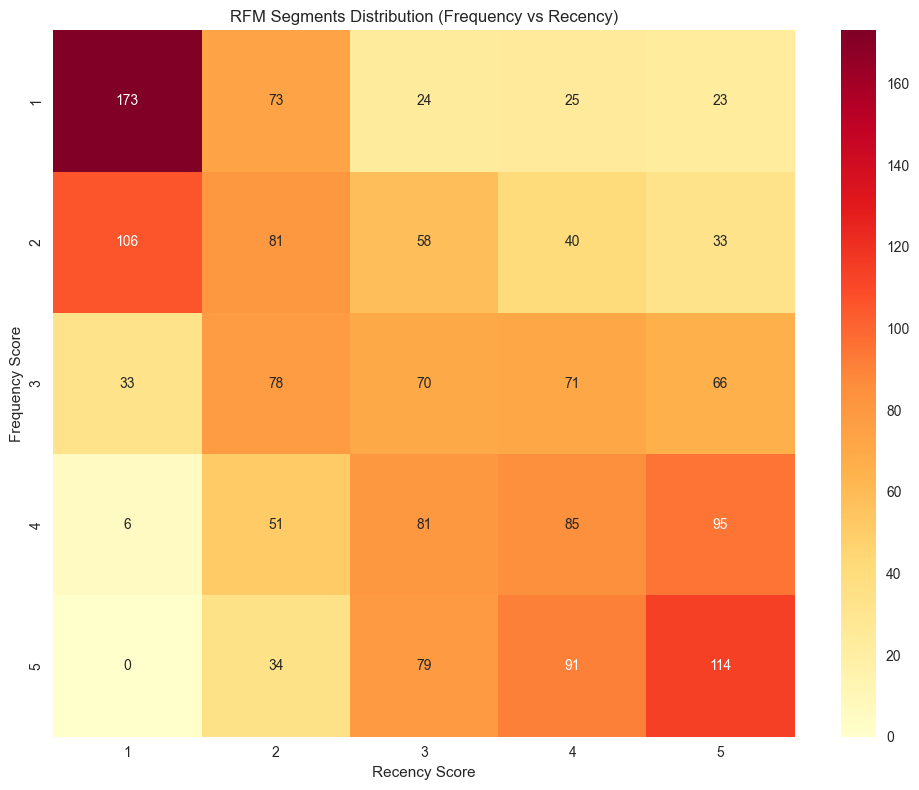

In [12]:
# Save RFM results
rfm.to_csv('../data/rfm_table.csv', index=False)

# RFM visualization - 3D scatter plot
fig = px.scatter_3d(rfm, 
                    x='Recency', 
                    y='Frequency', 
                    z='Monetary',
                    color='Customer_Segment',
                    hover_data=['Customer Name'],
                    title='RFM Customer Segmentation (3D View)',
                    labels={'Recency': 'Recency (Days)',
                           'Frequency': 'Frequency (Orders)',
                           'Monetary': 'Monetary Value ($)'})

fig.update_layout(height=600)
fig.show()

fig.write_html('../visuals/rfm_3d_segmentation.html')

# 2D RFM heatmap
rfm_pivot = rfm.pivot_table(values='Customer ID', 
                           index='F_Score', 
                           columns='R_Score', 
                           aggfunc='count', 
                           fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(rfm_pivot, annot=True, fmt='d', cmap='YlOrRd')
plt.title('RFM Segments Distribution (Frequency vs Recency)')
plt.xlabel('Recency Score')
plt.ylabel('Frequency Score')
plt.tight_layout()
plt.savefig('../visuals/rfm_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Segment distribution pie chart
fig = px.pie(segment_summary.reset_index(), 
             values='Count', 
             names='Customer_Segment',
             title='Customer Segment Distribution')

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(height=500)
fig.show()

fig.write_html('../visuals/customer_segments_pie.html')
fig.write_image('../visuals/customer_segments_pie.png', width=800, height=500)

## 7. Cohort Analysis

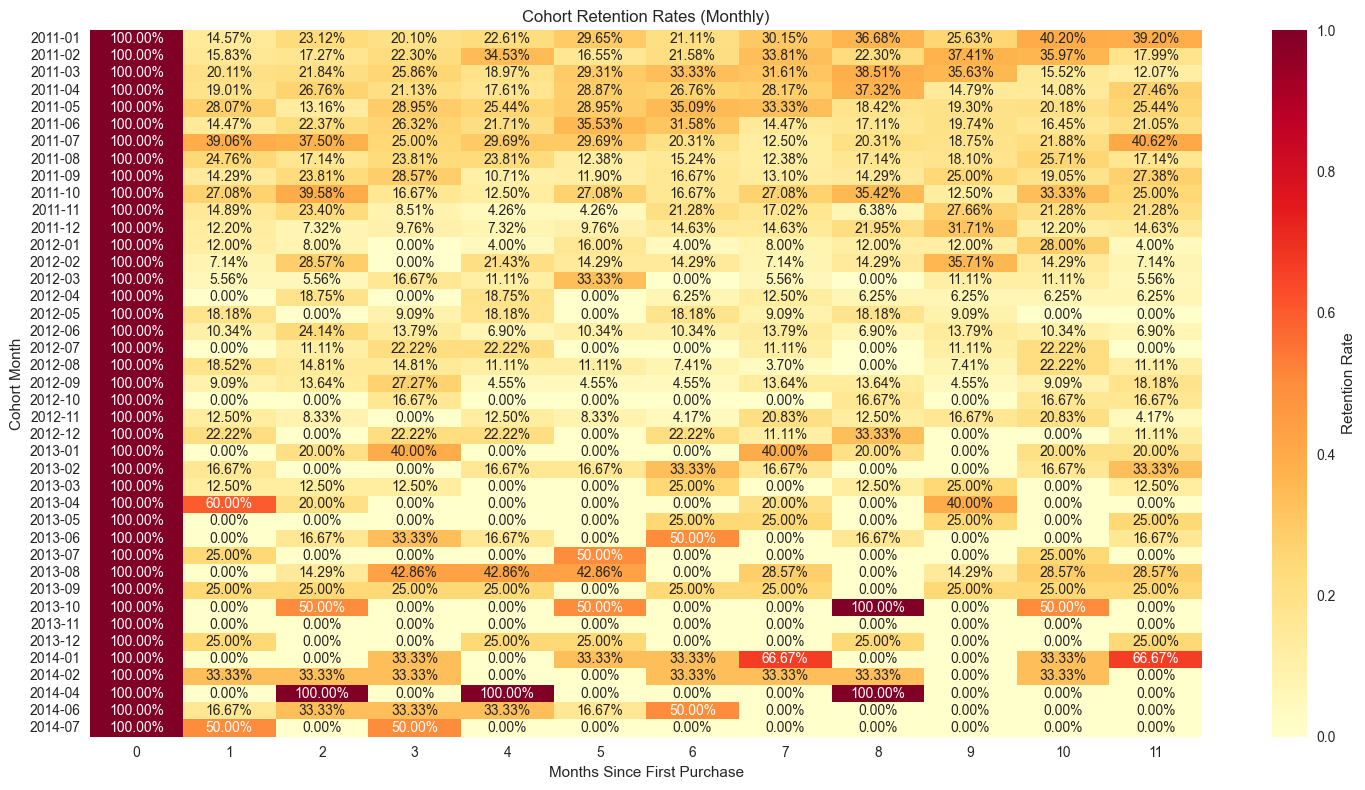

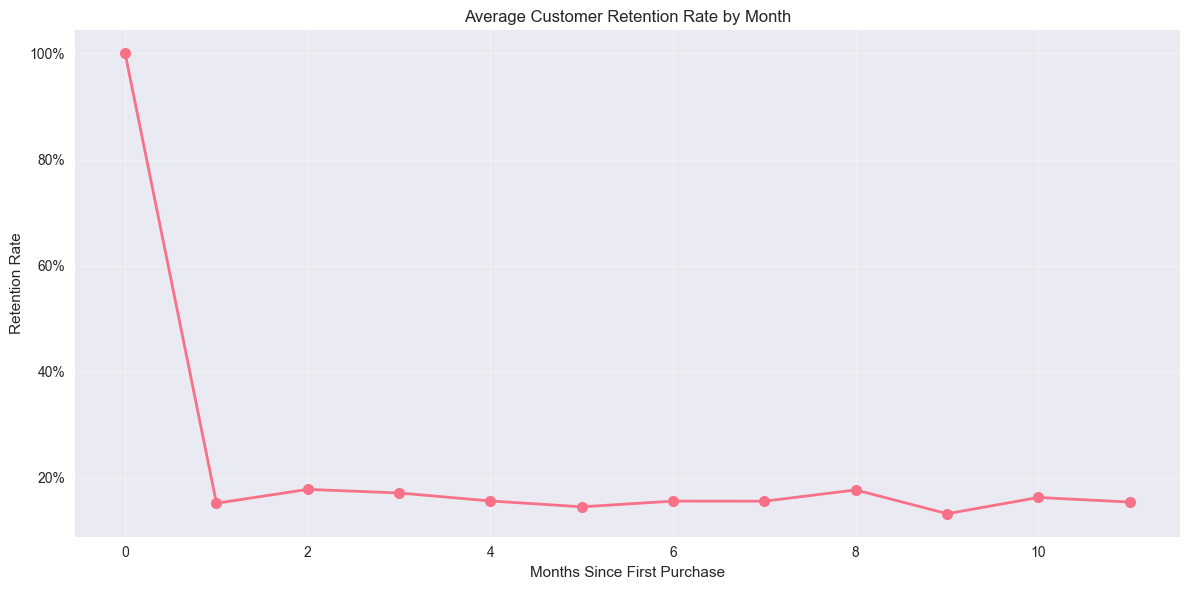

Average retention rates by month:
Month 0: 100.0%
Month 1: 15.2%
Month 2: 17.8%
Month 3: 17.2%
Month 4: 15.6%
Month 5: 14.5%


In [13]:
# Cohort analysis
df['Order_Month'] = df['Order Date'].dt.to_period('M')

# Get first purchase month for each customer
cohort_data = df.groupby('Customer ID')['Order_Month'].min().reset_index()
cohort_data.columns = ['Customer ID', 'Cohort_Month']

# Merge back with main dataframe
df_cohort = df.merge(cohort_data, on='Customer ID')

# Calculate months since first purchase
df_cohort['Months_Since_First_Purchase'] = (
    df_cohort['Order_Month'] - df_cohort['Cohort_Month']
).apply(lambda x: x.n)

# Create cohort table
cohort_table = df_cohort.pivot_table(
    index='Cohort_Month',
    columns='Months_Since_First_Purchase',
    values='Customer ID',
    aggfunc='nunique'
).fillna(0)

# Calculate retention rates
cohort_sizes = cohort_table.iloc[:, 0]
retention_table = cohort_table.divide(cohort_sizes, axis=0)

# Visualize cohort retention
plt.figure(figsize=(15, 8))
sns.heatmap(retention_table.iloc[:, :12], 
            annot=True, 
            fmt='.2%', 
            cmap='YlOrRd',
            cbar_kws={'label': 'Retention Rate'})
plt.title('Cohort Retention Rates (Monthly)')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.savefig('../visuals/cohort_retention.png', dpi=300, bbox_inches='tight')
plt.show()

# Average retention by month
avg_retention = retention_table.mean().iloc[:12]
plt.figure(figsize=(12, 6))
avg_retention.plot(kind='line', marker='o', linewidth=2, markersize=8)
plt.title('Average Customer Retention Rate by Month')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Retention Rate')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visuals/avg_retention_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("Average retention rates by month:")
for i, rate in enumerate(avg_retention.iloc[:6]):
    print(f"Month {i}: {rate:.1%}")

## 8. Seasonal Trends Analysis

In [14]:
# Seasonal analysis
df['Month'] = df['Order Date'].dt.month
df['Quarter'] = df['Order Date'].dt.quarter
df['Day_of_Week'] = df['Order Date'].dt.dayofweek
df['Month_Name'] = df['Order Date'].dt.month_name()
df['Day_Name'] = df['Order Date'].dt.day_name()

# Monthly seasonality
monthly_sales = df.groupby('Month_Name').agg({
    'Sales': 'sum',
    'Order ID': 'nunique'
}).reindex(['January', 'February', 'March', 'April', 'May', 'June',
           'July', 'August', 'September', 'October', 'November', 'December'])

# Weekly seasonality
weekly_sales = df.groupby('Day_Name').agg({
    'Sales': 'sum',
    'Order ID': 'nunique'
}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Create seasonal plots
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Monthly Sales Pattern', 'Weekly Sales Pattern')
)

# Monthly pattern
fig.add_trace(
    go.Bar(x=monthly_sales.index, y=monthly_sales['Sales'], 
           name='Monthly Sales', marker_color='lightblue'),
    row=1, col=1
)

# Weekly pattern
fig.add_trace(
    go.Bar(x=weekly_sales.index, y=weekly_sales['Sales'], 
           name='Weekly Sales', marker_color='lightcoral'),
    row=2, col=1
)

fig.update_layout(height=600, title_text="Seasonal Sales Patterns", showlegend=False)
fig.show()

fig.write_html('../visuals/seasonal_patterns.html')
fig.write_image('../visuals/seasonal_patterns.png', width=1200, height=600)

print("Top 3 months by sales:")
print(monthly_sales.sort_values('Sales', ascending=False).head(3))

print("\nTop 3 days by sales:")
print(weekly_sales.sort_values('Sales', ascending=False).head(3))

Top 3 months by sales:
                   Sales  Order ID
Month_Name                        
December    1.580781e+06      3166
November    1.551277e+06      3145
September   1.437380e+06      3021

Top 3 days by sales:
                 Sales  Order ID
Day_Name                        
Friday    2.322848e+06      4608
Tuesday   2.268417e+06      4632
Thursday  2.245837e+06      4433


## 9. Churn Analysis

In [15]:
# Churn analysis by segment
max_date = df['Order Date'].max()
churn_threshold = 90  # days

customer_last_order = df.groupby(['Customer ID', 'Segment']).agg({
    'Order Date': 'max',
    'Sales': 'sum',
    'Order ID': 'nunique'
}).reset_index()

customer_last_order['Days_Since_Last_Order'] = (
    max_date - customer_last_order['Order Date']
).dt.days

customer_last_order['Churned'] = customer_last_order['Days_Since_Last_Order'] > churn_threshold

# Churn rate by segment
churn_by_segment = customer_last_order.groupby('Segment').agg({
    'Churned': ['count', 'sum'],
    'Sales': 'mean'
}).round(2)

churn_by_segment.columns = ['Total_Customers', 'Churned_Customers', 'Avg_Customer_Value']
churn_by_segment['Churn_Rate'] = (
    churn_by_segment['Churned_Customers'] / churn_by_segment['Total_Customers'] * 100
).round(1)

# Visualize churn analysis
fig = px.bar(churn_by_segment.reset_index(), 
             x='Segment', 
             y='Churn_Rate',
             color='Avg_Customer_Value',
             title='Customer Churn Rate by Segment',
             labels={'Churn_Rate': 'Churn Rate (%)',
                    'Avg_Customer_Value': 'Avg Customer Value ($)'})

fig.update_layout(height=500)
fig.show()

fig.write_html('../visuals/churn_analysis.html')
fig.write_image('../visuals/churn_analysis.png', width=800, height=500)

print("Churn Analysis by Segment:")
print(churn_by_segment)

# Overall churn metrics
total_customers = len(customer_last_order)
churned_customers = customer_last_order['Churned'].sum()
overall_churn_rate = (churned_customers / total_customers) * 100

print(f"\nOverall Churn Metrics:")
print(f"Total Customers: {total_customers:,}")
print(f"Churned Customers: {churned_customers:,}")
print(f"Overall Churn Rate: {overall_churn_rate:.1f}%")

Churn Analysis by Segment:
             Total_Customers  Churned_Customers  Avg_Customer_Value  \
Segment                                                               
Consumer                 818                218             7955.93   
Corporate                476                136             8035.08   
Home Office              296                 84             7803.56   

             Churn_Rate  
Segment                  
Consumer           26.7  
Corporate          28.6  
Home Office        28.4  

Overall Churn Metrics:
Total Customers: 1,590
Churned Customers: 438
Overall Churn Rate: 27.5%


## 10. Summary and Key Insights

In [16]:
# Create comprehensive KPI dashboard
kpi_data = {
    'Metric': [
        'Total Revenue',
        'Total Profit', 
        'Profit Margin',
        'Total Orders',
        'Total Customers',
        'Average Order Value',
        'YoY Growth Rate',
        'Customer Churn Rate',
        'Customer Retention (Month 1)',
        'Champions Segment %'
    ],
    'Value': [
        f"${total_revenue:,.0f}",
        f"${total_profit:,.0f}",
        f"{overall_profit_margin:.1f}%",
        f"{total_orders:,}",
        f"{total_customers:,}",
        f"${avg_order_value:.2f}",
        f"{yoy_growth:.1f}%",
        f"{overall_churn_rate:.1f}%",
        f"{avg_retention.iloc[1]:.1%}",
        f"{segment_summary.loc['Champions', 'Percentage']:.1f}%"
    ]
}

kpi_df = pd.DataFrame(kpi_data)

print("=== EXECUTIVE DASHBOARD SUMMARY ===")
print(kpi_df.to_string(index=False))

# Save key insights to file
insights = f"""
SUPERSTORE ANALYSIS - KEY INSIGHTS
=====================================

BUSINESS PERFORMANCE:
• Total Revenue: ${total_revenue:,.0f} with {overall_profit_margin:.1f}% profit margin
• YoY Growth: {yoy_growth:.1f}% ({'positive' if yoy_growth > 0 else 'negative'} trend)
• Average Order Value: ${avg_order_value:.2f}

CUSTOMER INSIGHTS:
• Total Customers: {total_customers:,} with {overall_churn_rate:.1f}% churn rate
• Customer Retention: {avg_retention.iloc[1]:.1%} after 1 month
• Champions Segment: {segment_summary.loc['Champions', 'Percentage']:.1f}% of customers

TOP PERFORMERS:
• Best Region: {regional_perf.sort_values('Sales', ascending=False).iloc[0]['Region']} (${regional_perf.sort_values('Sales', ascending=False).iloc[0]['Sales']:,.0f})
• Best Category: {category_perf.sort_values('Sales', ascending=False).iloc[0]['Category']} (${category_perf.sort_values('Sales', ascending=False).iloc[0]['Sales']:,.0f})
• Peak Month: {monthly_sales.sort_values('Sales', ascending=False).index[0]} 

OPPORTUNITIES:
• Focus on '{churn_by_segment.sort_values('Churn_Rate', ascending=False).index[0]}' segment (highest churn: {churn_by_segment.sort_values('Churn_Rate', ascending=False).iloc[0]['Churn_Rate']:.1f}%)
• Develop retention programs for months 2-3 (retention drops to {avg_retention.iloc[2]:.1%})
• Optimize low-performing regions and categories
"""

with open('../data/analysis_insights.txt', 'w') as f:
    f.write(insights)

print(insights)

# Close database connection
conn.close()

print("\n=== ANALYSIS COMPLETE ===")
print("All visualizations saved to ../visuals/")
print("RFM data saved to ../data/rfm_table.csv")
print("Key insights saved to ../data/analysis_insights.txt")

=== EXECUTIVE DASHBOARD SUMMARY ===
                      Metric       Value
               Total Revenue $12,642,502
                Total Profit  $1,467,457
               Profit Margin       11.6%
                Total Orders      25,035
             Total Customers       1,590
         Average Order Value     $504.99
             YoY Growth Rate       26.3%
         Customer Churn Rate       27.5%
Customer Retention (Month 1)       15.2%
         Champions Segment %       21.8%

SUPERSTORE ANALYSIS - KEY INSIGHTS

BUSINESS PERFORMANCE:
• Total Revenue: $12,642,502 with 11.6% profit margin
• YoY Growth: 26.3% (positive trend)
• Average Order Value: $504.99

CUSTOMER INSIGHTS:
• Total Customers: 1,590 with 27.5% churn rate
• Customer Retention: 15.2% after 1 month
• Champions Segment: 21.8% of customers

TOP PERFORMERS:
• Best Region: Central ($2,822,303)
• Best Category: Technology ($4,744,557)
• Peak Month: December 

OPPORTUNITIES:
• Focus on 'Corporate' segment (highest churn: 28